In [237]:
# Imports
import sys
import random
import numpy as np
from random import randint
from sklearn import datasets
from functools import cmp_to_key
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.datasets import make_circles, load_breast_cancer, make_blobs, load_wine

# Problema da envoltória convexa
- A computação da envoltória convexa de um conjunto de pontos no plano
- Problema consiste em encontrar o menor polígono estritamente convexo que contenha um conjunto de pontos P
- Dessa forma, se H é a envoltória convexa de P, todo ponto de P está dentro ou na borda de H
- Além disso, todos os ângulos internos de H são menores que pi
- Logo, a solução para o problema é encontrar os vértices do polígono dentre os pontos de P

## Orientação relativa de segmentos de reta
- Dados **a** e **b** dois vetores 2d. 
    - Se **|a x b|** > 0, então **a** estão numa posição horária de **b**.
    - Se **|a x b|** < 0, então **a** está numa posição horária de **b**.
    - Se **|a x b|** = 0, então **a** e **b** são colineares.
    
- A seguinte função, retorna o valor do produto vetorial para a direção da rota por segmentos

In [238]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __lt__(self, p):
        return self.x < p.x or (self.x == p.x and self.y < p.y)
    
    def __sub__(self, p):
        return Point(self.x - p.x, self.y - p.y)
    
    def __add__(self, p):
        return Point(self.x + p.x, self.y + p.y)
    
    def __truediv__(self, p):
        return Point(self.x / p.x, self.y / p.y)
    
    def __mul__(self, p):
        return Point(self.x * p.x, self.y * p.y)
    
    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'

In [239]:
def direction(p1, p2, p3):
    return (p2.x - p1.x) * (p3.y - p1.y) \
        -(p2.y - p1.y) * (p3.x - p1.x)

- A seguinte função encontra a distância quadrática euclidiana
- Usada para determinar qual vértice deve ficar no casco da envoltória, caso dois vértices sejam colineares

In [240]:
def squaredDistance(point1, point2):
    x1, y1 = point1.x, point1.y
    x2, y2 = point2.x, point2.y
    dx = x2 - x1
    dy = y2 - y1
    distance_squared = dx**2 + dy**2
    return distance_squared

## Encontrar ponto âncora
- Encontrar o ponto com a menor coordenada y mais à esquerda (em caso de empates)
- Como esse ponto é o mais abaixo de todos, ele é uma escolha segura para ser um vértice da envoltória

In [241]:
def leftmost(points):
    leftMostIndex = 0
    for i in range(1,len(points)):
        if points[i].x < points[leftMostIndex].x:
            leftMostIndex = i
        elif points[i].x == points[leftMostIndex].x:
            if points[i].y > points[leftMostIndex].y:
                leftMostIndex = i
    return leftMostIndex

## Algoritmo embrulho para presente (gift wrapping)

- Proposto por R.A. Jarvis em 1973
- Possui complexidade O(nh), h é o número de vértices presentes no casco da envoltória
- Ideia do algoritmo:
    - Imagine que você tenha um conjunto de pregos em um tabuleiro (pontos)
    - Ate uma corda no prego mais ao sul do tabuleiro
    - Puxe a corda para a direita e depois para cima até encontrar o próximo prego
    - Ate a corda a esse prego e repita o processo até retornar o primeiro
- Formalmente:
    - Escolha um vértice para iniciar o processamento (vértice âncora)
    - Em seguida, repita até que o vértice atual seja o vértice âncora:
        - Encontre o vértice com o menor ângulo polar à esquerda do vértice atual e mova para ele

In [242]:
def giftWrapping(points):
    # find the leftmost point
    leftmostIndex = leftmost(points)
    leftmostPoint = points[leftmostIndex]

    # selection sort
    l = leftmostIndex
    hull = []
    hull.append(leftmostPoint)
    while (True):
        q = (l+1) % len(points)
        for i in range(len(points)):
            if i == l:
                continue
            # find the greates left turn
            # in case of collinearity, consider the farthest point
            d = direction(points[l], points[i], points[q])
            if d > 0 or (d == 0 and squaredDistance(points[i], points[l]) > squaredDistance(points[q], points[l])):
                q = i
            
        l = q
        if l == leftmostIndex:
            break
        hull.append(points[q])   

    return hull

## Testando o algoritmo embrulho para presente

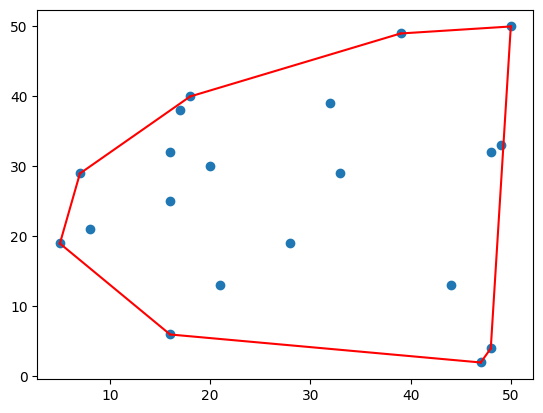

In [243]:
def create_points(ct, min = 0, max = 50):
    return [Point(randint(min, max), randint(min, max)) for _ in range(ct)]

def scatter_plot(coords, convex_hull = None):
    xs = []
    ys = []
    for coord in coords:
        xs.append(coord.x)
        ys.append(coord.y)

    plt.scatter(xs, ys)

    if convex_hull:
        for i in range(1, len(convex_hull) + 1):
            if i == len(convex_hull): i = 0 #wrap
            c0 = convex_hull[i-1]
            c1 = convex_hull[i]
            plt.plot((c0.x, c1.x), (c0.y, c1.y), 'r')
    plt.show()
    
points = create_points(20)
hull = giftWrapping(points)

scatter_plot(points, hull)

# Determinar se há interseção de segmentos em um conjunto
- Dado um conjunto de segmentos, queremos determinar se há interseção entre quaisquer dois elementos desse conjunto
- Para isso, primeiramente, é necessário definir um Segmento

In [244]:
class Segment:
    def __init__(self, p1, p2, sort_points=True):
        if sort_points: 
            if (p1.x < p2.x):
                self.p1 = p1
                self.p2 = p2
            else:
                self.p1 = p2
                self.p2 = p1
            if (self.p2.x - self.p1.x) == 0:
                self.p2.x += 0.05
        else:
            self.p1 = p1
            self.p2 = p2
        self.mi = (self.p2.y - self.p1.y) / (self.p2.x - self.p1.x)
        self.b = self.p1.y - (self.mi * self.p1.x)

    def __str__(self):
        return '(' + str(self.p1) + ', ' + str(self.p2) + ')'
    
    def __lt__(self, other):
        z = self
        currentX = z.p1.x
        zy = z.p1.y
        othery = other.getY(currentX)

        return zy < othery
    
    def __gt__(self, other):
        z = self
        currentX = z.p2.x
        zy = z.p2.y
        othery = other.getY(currentX)

        return zy > othery

    def getY(self, x):
        return (self.mi * x) + self.b

## Red black tree
- Como a relação é dinâmica (varia duante a varredura), precisamos de uma estrutura de dados capaz de permitir a execução das seguintes operações de forma eficiente:
    - Inserir um novo segmento s
    - Remover um segmento s
    - Descobrir o sucessor de s conforme a relação de ordem
    - Descobrir o antecessor de s conforme a relação de ordem
- Essas operações podem ser executadas em tempo O(log n), em que n é o número de segmentos, usando árvores binárias balanceadas
- No nosso contexto, utilizaremos a estrutura de dados de árvore rubro-negra
- Semelhante a uma árvore binária de pesquisa, mas com algumas propriedades adicionais que a tornam balanceada, garantindo um desempenho eficiente nas operações de inserção, exclusão e busca
- Características:
    1. **Cores dos nós:** Cada nó da árvore é atribuído a uma das duas cores: vermelho ou preto.
    2. **Propriedade de cores:** A árvore deve atender a várias propriedades, incluindo:
        - Cada nó é vermelho ou preto.
        - A raiz da árvore é sempre preta.
        - Todas as folhas (nós nulos) são pretas.
        - Se um nó é vermelho, então seus filhos devem ser pretos (nenhuma sequência de nós vermelhos pode ser conectada).
        - Qualquer caminho da raiz para uma folha deve ter o mesmo número de nós pretos.
- Essas propriedades garantem que a árvore permaneça relativamente balanceada, mesmo após a inserção ou exclusão de nós, o que limita a altura da árvore e, portanto, mantém o desempenho das operações em tempo logarítmico.

In [245]:
class Node:
  RED = True
  BLACK = False

  def __init__(self, value, color = RED):
    self.color = color
    self.value = value
    self.left = self.right = self.parent = NilNode.instance()

  def __str__(self, level = 0, indent = "   "):
    s = level * indent + str(self.value)
    if self.left:
      s = s + "\nL" + self.left.__str__(level + 1, indent)
    if self.right:
      s = s + "\nR" + self.right.__str__(level + 1, indent)
    return s

  def __nonzero__(self):
    return True

  def __bool__(self):
    return True


class NilNode(Node):
  __instance__ = None

  @classmethod
  def instance(self):
    if self.__instance__ is None:
      self.__instance__ = NilNode()
    return self.__instance__

  def __init__(self):
    self.color = Node.BLACK
    self.value = None
    self.left = self.right = self.parent = None

  def __nonzero__(self):
    return False

  def __bool__(self):
    return False

class RedBlackTree:
  def __init__(self):
    self.root = NilNode.instance()
    self.size = 0
    
  def __str__(self):
    return ("(root.size = %d)\n" % self.size)  + str(self.root)

  def add(self, value):
    self.insert(Node(value))

  def insert(self, x):
    self.__insert_helper(x)

    x.color = Node.RED
    while x != self.root and x.parent.color == Node.RED:
      if x.parent == x.parent.parent.left:
        y = x.parent.parent.right
        if y and y.color == Node.RED:
          x.parent.color = Node.BLACK
          y.color = Node.BLACK
          x.parent.parent.color = Node.RED
          x = x.parent.parent
        else:
          if x == x.parent.right:
            x = x.parent
            self.__left_rotate(x)
          x.parent.color = Node.BLACK
          x.parent.parent.color = Node.RED
          self.__right_rotate(x.parent.parent)
      else:
        y = x.parent.parent.left
        if y and y.color == Node.RED:
          x.parent.color = Node.BLACK
          y.color = Node.BLACK
          x.parent.parent.color = Node.RED
          x = x.parent.parent
        else:
          if x == x.parent.left:
            x = x.parent
            self.__right_rotate(x)
          x.parent.color = Node.BLACK
          x.parent.parent.color = Node.RED
          self.__left_rotate(x.parent.parent)
    self.root.color = Node.BLACK

  def delete(self, z):
    if not z.left or not z.right:
      y = z
    else:
      y = self.successor(z)
    if not y.left:
      x = y.right
    else:
      x = y.left
    x.parent = y.parent

    if not y.parent:
      self.root = x
    else:
      if y == y.parent.left:
        y.parent.left = x
      else:
        y.parent.right = x

    if y != z: z.value = y.value

    if y.color == Node.BLACK:
      self.__delete_fixup(x)

    self.size -= 1
    return y

  def minimum(self, x = None):
    if x is None: x = self.root
    while x.left:
      x = x.left
    return x

  def maximum(self, x = None):
    if x is None: x = self.root
    while x.right:
      x = x.right
    return x

  def successor(self, x):
    if x.right:
      return self.minimum(x.right)
    y = x.parent
    while y and x == y.right:
      x = y
      y = y.parent
    return y

  def predecessor(self, x):
    if x.left:
      return self.maximum(x.left)
    y = x.parent
    while y and x == y.left:
      x = y
      y = y.parent
    return y

  def search(self, value, x = None):
    if x is None: x = self.root
    while x and x.value != value:
      if value > x.value:
        x = x.right
      else:
        x = x.left
    return x

  def is_empty(self):
    return bool(self.root)

  def __left_rotate(self, x):
    if not x.right:
      raise "x.right is nil!"
    y = x.right
    x.right = y.left
    if y.left: y.left.parent = x
    y.parent = x.parent
    if not x.parent:
      self.root = y
    else:
      if x == x.parent.left:
        x.parent.left = y
      else:
        x.parent.right = y
    y.left = x
    x.parent = y

  def __right_rotate(self, x):
    if not x.left:
      raise "x.left is nil!"
    y = x.left
    x.left = y.right
    if y.right: y.right.parent = x
    y.parent = x.parent
    if not x.parent:
      self.root = y
    else:
      if x == x.parent.left:
        x.parent.left = y
      else:
        x.parent.right = y
    y.right = x
    x.parent = y

  def __insert_helper(self, z):
    y = NilNode.instance()
    x = self.root
    while x:
      y = x
      if z.value < x.value:
        x = x.left
      else:
        x = x.right

    z.parent = y
    if not y:
      self.root = z
    else:
      if z.value < y.value:
        y.left = z
      else:
        y.right = z
    
    self.size += 1

  def __delete_fixup(self, x):
    while x != self.root and x.color == Node.BLACK:
      if x == x.parent.left:
        w = x.parent.right
        if w.color == Node.RED:
          w.color = Node.BLACK
          x.parent.color = Node.RED
          self.__left_rotate(x.parent)
          w = x.parent.right
        if w.left.color == Node.BLACK and w.right.color == Node.BLACK:
          w.color = Node.RED
          x = x.parent
        else:
          if w.right.color == Node.BLACK:
            w.left.color = Node.BLACK
            w.color = Node.RED
            self.__right_rotate(w)
            w = x.parent.right
          w.color = x.parent.color
          x.parent.color = Node.BLACK
          w.right.color = Node.BLACK
          self.__left_rotate(x.parent)
          x = self.root
      else:
        w = x.parent.left
        if w.color == Node.RED:
          w.color = Node.BLACK
          x.parent.color = Node.RED
          self.__right_rotate(x.parent)
          w = x.parent.left
        if w.right.color == Node.BLACK and w.left.color == Node.BLACK:
          w.color = Node.RED
          x = x.parent
        else:
          if w.left.color == Node.BLACK:
            w.right.color = Node.BLACK
            w.color = Node.RED
            self.__left_rotate(w)
            w = x.parent.left
          w.color = x.parent.color
          x.parent.color = Node.BLACK
          w.left.color = Node.BLACK
          self.__right_rotate(x.parent)
          x = self.root
    x.color = Node.BLACK

## Determinar se dois segmentos se interceptam
- Podemos verificar se dois segmentos se interceptam, verificando se eles cruzam as retas que os sobrepõem
- Dois segmentos se interceptam se, e somente se, uma das seguintes condições se aplica:
    - Cada segmento atravessa a reta que se sobrepõe ao outro segmento
    - Um dos terminais de um segmento se encontra sobre o outro segmento
- Podemos usar a orientação relativa de segmentos para verificar se um segmento atravessa a reta que se sobrepõe ao outro
    - Um segmento atravessa uma reta se seus pontos estão em lados opostos da reta
- Contudo, se verificarmos que algum dos pontos entre dois segmentos são colineares, então devemos verificar se o ponto avaliado se sobrepõe ao segmento testado
    - Basta verificar se as coordenadas estão dentro do intervalo definido pelos dois terminais do segmento

In [246]:
# checks if p lies on the segment p1p2
def onSegment(p1, p2, p):
    return min(p1.x, p2.x) <= p.x <= max(p1.x, p2.x) and min(p1.y, p2.y) <= p.y <= max(p1.y, p2.y)

In [247]:
# checks if line segment p1p2 and p3p4 intersect
def intersect(s1, s2):
    p1 = s1.p1
    p2 = s1.p2
    p3 = s2.p1
    p4 = s2.p2

    d1 = direction(p3, p4, p1)
    d2 = direction(p3, p4, p2)
    d3 = direction(p1, p2, p3)
    d4 = direction(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and \
        ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and onSegment(p3, p4, p1):
        return True
    elif d2 == 0 and onSegment(p3, p4, p2):
        return True
    elif d3 == 0 and onSegment(p1, p2, p3):
        return True
    elif d4 == 0 and onSegment(p1, p2, p4):
        return True
    else:
        return False

## Algoritmo para determinar se há interseção de segmentos em um conjunto
- Utilizaremos a estratégia de varredura linear (sweeping)
- Nessa abordagem, uma reta vertical imaginária é varrida sobre os objetos geométricos, no nosso caso, da esquerda para a direita
- Processaremos os segmentos em ordem conforme a varredura dos pontos que os definem
- Definiremos uma ordem sobre os segmentos de acordo com a coordenada y de suas interseções com a reta de varredura
- Dados dois segmentos *s1* e *s2* e a reta de varredura x, *s1* e *s2* são **x-comparáveis** se a reta intercepta ambos os segmentos
- O segmento *s1* está **acima** de *s2* conforme a reta x, se *s1* E *s2* são x-comparáveis e a coordenada y da interseção de *s1* com x é maior que de *s2*, ou ambos se interceptam em x
- Note que a ordem dos segmentos, segundo a relação, varia para diferentes valores de x
- Os segmentos entram e saem da relação à medida que a varredura avança
    - Um segmento entra na relação quando seu ponto inicial é lido, e sai quando o final é lido
- Há um valor de x para o qual s1 e s2 se tornam consecutivos
    - Nesse momento, é avaliado se há interseção entre s1 e s2
- Já que essa relação é dinâmica, usamos a árvore rubro-negra, já supracita de explicada, para permitir a inserção, remoção e busca de segmentos
- A varredura feita pelo algoritmo é baseada nos pontos terminais dos segmentos (chamados de eventos)
- Os eventos são ordenados pela coordenada x. Desempates são baseados se são pontos de início ou fim, e na coordenada y

In [248]:
def compareEvents(ev1, ev2):
    p1 = ev1['point']
    p2 = ev2['point']
    if p1.x < p2.x:
        return -1
    elif p1.x > p2.x:
        return 1
    
    isTerminal1 = ev1['isTerminal']
    isTerminal2 = ev2['isTerminal']
    if isTerminal1 < isTerminal2:
        return -1
    elif isTerminal1 > isTerminal2:
        return 1
    
    if p1.y < p2.y:
        return -1
    elif p1.y > p2.y:
        return 1
    
    return 0
                
def anySegmentsIntersect(S):
    T = RedBlackTree()

    events = []
    for segmentIndex, segment in enumerate(S):
        events.append({
            'point': segment.p1,
            'segmentIdx': segmentIndex,
            'isTerminal': 0
        })
        events.append({
            'point': segment.p2,
            'segmentIdx': segmentIndex,
            'isTerminal': 1
        })

    events = sorted(events, key=cmp_to_key(compareEvents))

    for ev in events:
        segment = S[ev['segmentIdx']]
        
        if not ev['isTerminal']:
            node = Node(segment)
            T.insert(node)

            predecessor = T.predecessor(node)
            if predecessor and intersect(segment, predecessor.value):
                return True
            
            sucessor = T.successor(node)
            if sucessor and intersect(segment, sucessor.value):
                return True
        
        if ev['isTerminal']:
            node = T.search(segment)
            predecessor = T.predecessor(node)
            sucessor = T.successor(node)
            if predecessor and sucessor and intersect(predecessor.value, sucessor.value):
                return True
            T.delete(node)
    
    return False

## Testando o algoritmo para determinar se há interseção de segmentos em um conjunto

False


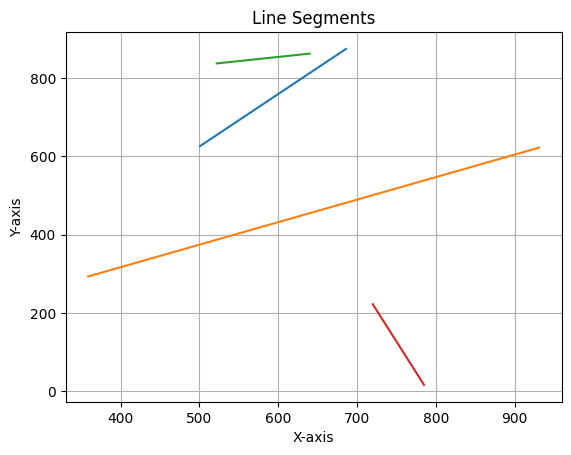

In [249]:
def generateSegment(min, max):
    x1 = randint(min, max)  
    y1 = randint(min, max)  
    x2 = randint(min, max)  
    y2 = randint(min, max) 
    section = ((x1, y1), (x2, y2))
    return section

def generateSegments(count, min, max):
    segments = []
    for _ in range(0, count):
        segment = generateSegment(min, max)
        segments.append(segment)
    return segments

segmentsOriginal = generateSegments(4, 0, 1000)

segments = map(
    lambda points: 
    Segment(
        Point(points[0][0], points[0][1]), 
        Point(points[1][0], points[1][1])
    ), 
    segmentsOriginal
)

segments = list(segments)


print(anySegmentsIntersect(segments))
# Extract x and y coordinates for plotting
x_values = [x for segment in segmentsOriginal for x, y in segment]
y_values = [y for segment in segmentsOriginal for x, y in segment]

# Plot line segments
for segment in segmentsOriginal:
    x1, y1 = segment[0]
    x2, y2 = segment[1]
    plt.plot([x1, x2], [y1, y2])

# Customize the plot (labels, title, etc.)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Line Segments")

# Show the plot
plt.grid(True)
plt.show()

# Determinar se duas envoltórias convexas são linearmente separáveis
- Para verificar a separabilidade dos dados, primeiramente, nosso método computa as envoltórias convexas de cada classe, considerando que os dados possuem apenas dois rótulos
- Em seguida, é verificado se há ou não sobreposição entre essas classes/envoltórias através do algoritmo já implementado de varredura lineara para a verificação de interseção de segmentos
- Caso não haja interseção entre segmentos de envoltórias distintas, então os dados são linearmente separáveis

## Definição de função auxiliar para a plotagem de gráficos, para facilitar a visualização dos dados

In [250]:
points1 = create_points(50, 0, 50)
hull1 = giftWrapping(points1)

points2 = create_points(50, 50, 100)
hull2 = giftWrapping(points2)
    

def scatterPlots(classification1, classification2):
    xs1 = []
    ys1 = []
    coords1 = classification1[0]
    hull1 = classification1[1]
    for coord in coords1:
        xs1.append(coord.x)
        ys1.append(coord.y)

    plt.scatter(xs1, ys1, color='blue')

    for i in range(1, len(hull1) + 1):
        if i == len(hull1): i = 0 #wrap
        c0 = hull1[i-1]
        c1 = hull1[i]
        plt.plot((c0.x, c1.x), (c0.y, c1.y), 'r')


    xs2 = []
    ys2 = []
    coords2 = classification2[0]
    hull2 = classification2[1]
    for coord in coords2:
        xs2.append(coord.x)
        ys2.append(coord.y)

    plt.scatter(xs2, ys2, color='green')

    for i in range(1, len(hull2) + 1):
        if i == len(hull2): i = 0 #wrap
        c0 = hull2[i-1]
        c1 = hull2[i]
        plt.plot((c0.x, c1.x), (c0.y, c1.y), 'y')


## Funções para determinar se duas envoltórias convexas se sobrepõem
- Para isso, com as envoltórias convexas para cada uma das duas classes definidas, é preciso executar o algoritmo da varredura linear
- Porém, se executarmos esse algoritmo diretamente com os segmentos das duas envoltórias convexas juntos, teremos um comportamento inesperado, já que o algoritmo detectará que os segmentos vizinhos de uma mesma envoltória se intercectam
- Para evitar isso, realizamos o seguinte tratamento:
    - Dividimos os vértices de cada envoltória convexa entre pares ou ímpares, dessa forma, cada envoltória convexa possuíra dois conjuntos de segmentos
    - Nenhum segmento em um mesmo conjunto é vizinho de outro
    - Considerando os conjuntos par1 e impar1 para a primeira envoltória convexa e par2 e impar2 para a segunda envoltória, executamos o algoritmo da seguinte forma:
        - Varredura linear entre par1 e par2
        - Varredura linear entre par1 e impar2
        - Varredura linear entre impar1 e par2
        - Varredura linear entre impar1 e impar2
    - Dessa forma, realizamos a comparação entre todos os elementos da envoltória 1 com a 2, sem ter o problema de segmentos de uma mesma envoltória identificarem uma interseção
    - Também existe um caso específico, caso a envoltória possua um total de lados ímpar, é necessário criar mais um conjunto de segmentos, contendo somente o último segmento, já que é ímpossível ele ficar em algum dos dois grupos sem ser vizinho de um outro segmento do conjunto

In [251]:
def hullToSegments(hull):
    segments = []
    prevPoint = hull[0]
    for i in range(1, len(hull)):
        segments.append(Segment(prevPoint, hull[i]))
        prevPoint = hull[i]
    segments.append(Segment(prevPoint, hull[0]))
    return segments

def splitSegments(segments):
    returnSegments = []
    n = len(segments)
    if (len(segments) % 2 == 1):
        n -= 1
        returnSegments.append([segments[n]])

    evenSegments = []
    oddSegments = []
    for i in range(0, n):
        if i % 2 == 0:
            evenSegments.append(segments[i])
        else:
            oddSegments.append(segments[i])

    returnSegments.append(evenSegments)
    returnSegments.append(oddSegments)
    return returnSegments
       
    
def hullIntersects(hull1, hull2):
    segments1 = hullToSegments(hull1)
    segments2 = hullToSegments(hull2)

    splittedSegments1 = splitSegments(segments1)
    splittedSegments2  = splitSegments(segments2)

    for segments1 in splittedSegments1:
        for segments2 in splittedSegments2:
            if anySegmentsIntersect(segments1 + segments2):
                return True
    return False


## Determinar se uma envoltória está contida na outra
- Caso não encontremos nenhuma interseção entre as duas envoltórias, ainda é necessário realizar uma última verificação
- Nesse sentido, é preciso verificar se uma envoltória não está contida dentro da outra
- Para isso, considerando um ponto arbitrário *p* da envoltória 1 e o polígono *e* formado pela envoltória 2,usamos o seguinte o algoritmo
    - Projetar uma reta a partir de *p* e contar o número de interseções
    - Caso o número de interseções seja ímpar, a envoltória 1 está contida pela envoltória 2, portanto, elas não são linearmente separáveis
    - Caso o número de interseções seja par, a envoltória 1 não está contida pela envoltória 2, porém, é necessário realizar a verificação inversa também
- Se as envoltórias não apresentarem intereseções e nenhuma das duas estiverem contidas, então as envoltórias são linearmente separáveis

In [252]:
largestInt = sys.maxsize

def isInside(poly, p):
    n = len(poly)
    if n < 3:
        return False
    
    exline = Segment(p, Point(largestInt, p.y ))
    count = 0
    for i in range(0, n):
        j = (i + 1) % n
        side = Segment(poly[i], poly[j])
        if intersect(side, exline):
            # plt.plot([side.p1.x, side.p2.x], [side.p1.y, side.p2.y], color='green')
            count += 1

    if count % 2 == 0:
        return False 
    # print("OUTRA COMPARACAO")
    # print('count ', count)
    # plt.plot([exline.p1.x, 1], [exline.p1.y, exline.p2.y], color='black')
    # plt.show()
    return True

## Unindo verificações de Separabilidade
- Une os dois conceitos anteriormente supracitados e realiza a verficação de separabilidade dos dados gerados para teste

As envoltórias são linearmente separáveis!


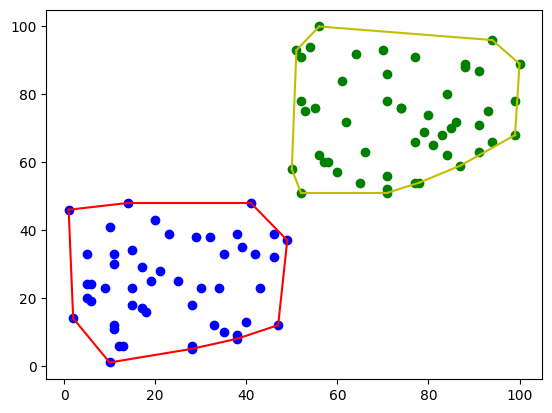

In [253]:
def isLinearlySeparable(hull1, hull2):
    if hullIntersects(hull1, hull2):
        return False
    
    if isInside(hull1, hull2[0]) or isInside(hull2, hull1[0]):
        return False
    
    return True

printAux = '' if isLinearlySeparable(hull1, hull2) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')
scatterPlots((points1, hull1), (points2, hull2))
plt.show()

# Gerar modelos lineares
- Para gerar os modelos lineares, o algoritmo utilizará as envoltórias convexas computadas na etapa anterior
## Encontrar pontos mais próximos
- O seguinte algoritmo encontra os pontos mais próximos entra as duas envoltórias.
- A ideia geral é de pegar um ponto aleatório **p** de uma das envoltórias convexas.
- A partir dele encontrar o ponto mais próximo a ele que faz parte da outra envoltória **p'**.
- A partir do ponto **p'** encontrar o ponto mais próximo na primeira envoltória novamente.
- Nesse momento encontramos os dois pontos mais próximos da envoltória em tempo linear.


In [254]:
# function receives two list of points and returns the closest pair of points between them
def getClosestPoints(hull1, hull2):
    closestPoint1 = Point(0, 0)
    closestPoint2 = Point(0, 0)

    auxPoint = hull1[0]
    minDistance = largestInt
    minDistancePoint = hull2[0]
    for point in hull2:
        distance = squaredDistance(auxPoint, point)
        if distance < minDistance:
            minDistance = distance
            minDistancePoint = point

    closestPoint2 = minDistancePoint

    minDistance = largestInt
    minDistancePoint
    for point in hull1:
        distance = squaredDistance(closestPoint2, point)
        if distance < minDistance:
            minDistance = distance
            minDistancePoint = point

    closestPoint1 = minDistancePoint

    return (closestPoint1, closestPoint2)

## Encontrar reta perpendicular
- O modelo a ser reportado será a reta perpendicular ao segmento que une os dois pontos mais próximos e passa sobre seu ponto médio
- Dessa forma, o modelo que será reportado é a equação dessa reta

## Encontrar ponto médio do segmento
- A função é bem simples e apenas pega os pontos **p1** e **p2** de um segmento e calcula a média das somas dos valores em x e y dos dois pontos, encontrando assim, o ponto médio do segmento.
- A pesar da função envolver duas divisões, como o valor divido é sempre o escalar 2, consideramos-a como O(1).

In [255]:
def middle_point(segment):
    # Calculate the midpoint
    mid_x = (segment.p1.x + segment.p2.x) / 2
    mid_y = (segment.p1.y + segment.p2.y) / 2
    return Point(mid_x, mid_y)

## Encontrar o ângulo entre dois segmentos
- Essa função determina o ânguo de incidência entre dois segmentos.
- O objetivo da função é apenas para verificar se a reta do modelo de separação é realmente perpendicular ao segmento dos pontos mais próximos.
- Com o auxílio da biblioteca numpy, o processo de calcular o ângulo é bem direto com a utilização de vetores.
- Dado que a função não é utilizada no algoritmo final, a complexidade da função não é relevante.

In [256]:
def calculate_angle(segment1, segment2):
    # Calculate the direction vectors of the two line segments
    vector1 = np.array([segment1.p2.x - segment1.p1.x, segment1.p2.y - segment1.p1.y])
    vector2 = np.array([segment2.p2.x - segment2.p1.x, segment2.p2.y - segment2.p1.y])

    # Calculate the dot product of the direction vectors
    dot_product = np.dot(vector1, vector2)

    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine of the angle between the segments
    cosine_theta = dot_product / (magnitude1 * magnitude2)

    # Calculate the angle in radians
    angle_radians = np.arccos(cosine_theta)

    # Convert the angle from radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

## Encontrar Segmento Ortogonal
- Essa função é utilizada para determinar a reta ortogonal ao segmento dos pontos mais próximos.
- Ela recebe como parâmetro metade deste segmento, sendo esse novo segmento formado por um dos pontos das extremidades do segmento original e o ponto médio do segmento.
- Utilizando a inversão de valores do vetor projetado é possível calcular um ponto **p** que juntamente com o ponto médio do segmento original configura um novo segmento que é ortogonal ao segmento original, e, além disso, intersecta-o no meio.
- Como a classe **Segment** já calcula a função afim do segmento a partir dos pontos de suas extremidades, já temos o modelo de separação linear.

In [257]:
def orthogonal_segment(half_segment):
    # Calculate the vector representing the initial segment
    initial_vector = (half_segment.p2.x - half_segment.p1.x, half_segment.p2.y - half_segment.p1.y)

    # Calculate a vector orthogonal to the initial segment
    orthogonal_vector = (-initial_vector[1], initial_vector[0])

    # Calculate the endpoint of the new segment
    x2 = half_segment.p2.x + orthogonal_vector[0]
    y2 = half_segment.p2.y + orthogonal_vector[1]

    initial_point = Point(half_segment.p2.x, half_segment.p2.y)
    orthogonal_point = Point(x2, y2)

    return Segment(initial_point, orthogonal_point, False)

## Encontrando Separação Linear
- Dado como entrada os dois pontos mais próximos entre as envoltórias.
- A partir daí a função ira orquestrar a chamada às funções anteriormente mencionadas a fim de determinar o segmento de separação linear.

In [258]:
def getLinearSeparationSegment(closestPoints):
  # Find closest segment between hulls
  closest_points_segment = Segment(closestPoints[0], closestPoints[1])

  # Find the middle point of the closest segment
  middle_point_from_closest = middle_point(closest_points_segment)

  # Find the orthogonal segment to the closest segment
  separation_segment = orthogonal_segment(Segment(closestPoints[0], middle_point_from_closest, False))

  return separation_segment

## Testando Separação Linear
- Nesse momento a função `calculate_angle` é utilizada para garantir que, no cenário de teste, a reta gerada é realmente ortogonal à reta de separação dos pontos mais próximos.
- Apesar da aparência ilusória gerada pela demonstração gráfica da reta, podemos verificar que as retas são ortogonais dado o ângulo de 90°

In [259]:
def linearSeparationPlot(closest_points_segment, separation_segment):
  plt.plot((closest_points_segment.p1.x, closest_points_segment.p2.x), (closest_points_segment.p1.y, closest_points_segment.p2.y), 'cyan')
  plt.scatter([closest_points_segment.p1.x, closest_points_segment.p2.x], [closest_points_segment.p1.y, closest_points_segment.p2.y], color='cyan')

  plt.scatter(separation_segment.p1.x, separation_segment.p1.y, color='purple')

  plt.scatter(separation_segment.p2.x, separation_segment.p2.y, color='purple')
  plt.axline((separation_segment.p1.x, separation_segment.p1.y), (separation_segment.p2.x, separation_segment.p2.y), color='purple')

Angle between segments: 90.0°


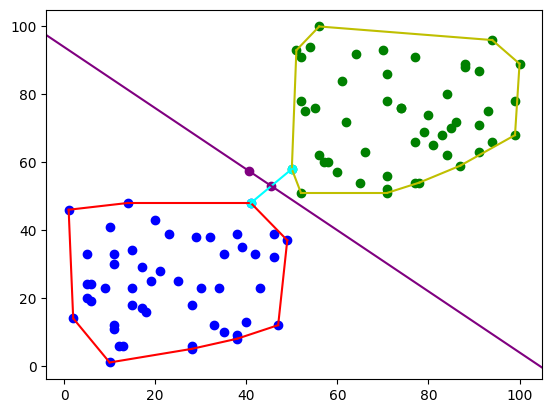

In [260]:
# only used for plotting
closestPoints = getClosestPoints(hull1, hull2)
closest_points_segment = Segment(closestPoints[0], closestPoints[1])

separation_segment = getLinearSeparationSegment(closestPoints)

angle = calculate_angle(closest_points_segment, separation_segment)
print("Angle between segments: " + str(angle) + "°")

scatterPlots((points1, hull1), (points2, hull2))
linearSeparationPlot(closest_points_segment, separation_segment)

plt.show()

## Classificação de um ponto
- Dado um ponto como entrada e um segmento de separação, utiliza-se o método `getY` do segmento de separação para determinar se, para um dado valor **x** do ponto de entrada, se o valor **y** da reta para aquele **x** é menor ou maior que o da reta pra o mesmo valor **x**.

In [261]:
clusterEnum = {
  'FIRST': 'first',
  'SECOND': 'second'
}
def getPointCluster(point, separation_segment):
  y_on_function = separation_segment.getY(point.x)

  return clusterEnum['FIRST'] if point.y < y_on_function else clusterEnum['SECOND']

## Classificação de pontos em Clusters
- Tendo como entrada um array de pontos, e uma reta de separação.
- A função utiliza-se da anterior para determinar a qual cluster cada ponto do array pertence.
- Dada a classificação, o ponto é direcionado para um dos clusters, sendo direcionado para o primeiro caso o valor de **y** do ponto seja menor que o da reta, e para o segundo caso contrário.
- A função retorna uma tupla contendo os dois clusters.

In [262]:
def classifyPoints(points, separation_segment):
  firstCluster = []
  secondCluster = []

  for point in points:
    cluster = getPointCluster(point, separation_segment)
    if cluster == clusterEnum['FIRST']:
      firstCluster.append(point)
    else:
      secondCluster.append(point)

  return (firstCluster, secondCluster)

## Testando Classificação dos Pontos

In [263]:
def plotClusters(classification):
  firstCluster = classification[0]
  secondCluster = classification[1]

  xs1 = []
  ys1 = []
  for coord in firstCluster:
    xs1.append(coord.x)
    ys1.append(coord.y)

  plt.scatter(xs1, ys1, color='pink')

  xs2 = []
  ys2 = []
  for coord in secondCluster:
    xs2.append(coord.x)
    ys2.append(coord.y)

  plt.scatter(xs2, ys2, color='orange')

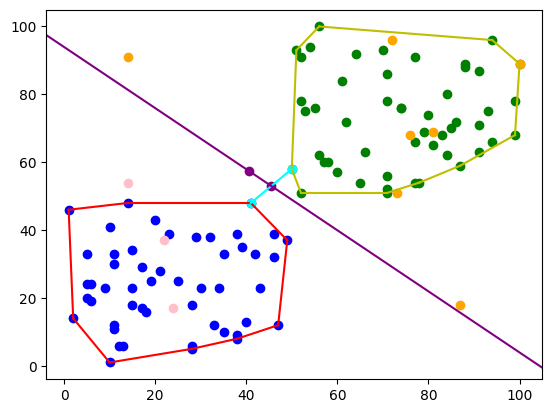

In [264]:
points3 = create_points(10, 0, 100)
classification = classifyPoints(points3, separation_segment)

scatterPlots((points1, hull1), (points2, hull2))
linearSeparationPlot(closest_points_segment, separation_segment)
plotClusters(classification)

plt.show()

## Normalização

- A função `min_max_scaling` é utilizada para realizar a escala de pontos de dados em um novo intervalo, conhecido como escala mínimo-máximo (min-max scaling). 
- Essa técnica é comumente usada para normalizar dados para um intervalo específico, como [0, 1].
- A função retorna uma tupla contendo duas funções:
    1. `min_max_scaling_transform`: Uma função que escala um ponto de dados do intervalo original para o novo intervalo definido por `new_min` e `new_max`.
    2. `min_max_scaling_revert`: Uma função que reverte a escala, mapeando um ponto do novo intervalo de volta para o intervalo original.
- Essa normalização dos pontos é necessária para casos em que os atributos utilizados em comparação apresentam escala muito distinta
- Nesse caso, é importante usar a normalização para o cálculo dos pontos mais próximas, que utiliza a distância quadrática euclidiana e também para o cálculo do ponto médio na reta de separação

In [265]:
def min_max_scaling(points, new_min=0, new_max=1):    
    new_min = Point(new_min, new_min)
    new_max = Point(new_max, new_max)

    # Find the minimum and maximum values in the list of points
    min_val_x = points[0].x
    min_val_y = points[0].y
    max_val_x = points[0].x
    max_val_y = points[0].y
    for point in points:
        if point.x < min_val_x:
            min_val_x = point.x
        if point.y < min_val_y:
            min_val_y = point.y
        if point.x > max_val_x:
            max_val_x = point.x
        if point.y > max_val_y:
            max_val_y = point.y

    min_val = Point(min_val_x, min_val_y)
    max_val = Point(max_val_x, max_val_y)

    # Calculate the range of values
    value_range = max_val - min_val

    def min_max_scaling_transform(point):
      # Scale the point to the new range
      scaled_point = ((point - min_val) / value_range) * (new_max - new_min) + new_min

      return scaled_point

    def min_max_scaling_revert(scaled_point):
      # Map the scaled point back to the original range
      original_point = (scaled_point - new_min) * value_range / (new_max - new_min) + min_val

      return original_point

    return (min_max_scaling_transform, min_max_scaling_revert)

In [266]:
def datasetToPoints(dataset):
    points = []
    for element in dataset:
      points.append(Point(element[0], element[1]))
    return points

## Segmentação de dados para Teste e Treinamento
- A função recebe um array de pontos e um percentual de treinamento (0 até 100).
- Após isso, o array de pontos recebe uma nova ordenação aleatória, a fim de evitar enviezamentos por ordenações anteriores.
- Depois os dados são segmentados utilizando um índice de separação, que é trivialmente calculado.

In [267]:
def trainTestSplit(data, trainPercent):
    # Check if the train_percent is within a valid range
    if trainPercent < 0 or trainPercent > 100:
        raise ValueError("trainPercent should be between 0 and 100")

    # Shuffle the data to randomize the order
    random.shuffle(data)

    # Calculate the split index based on the train_percent
    split_index = int(len(data) * trainPercent / 100)

    # Split the data into training and test sets
    training_data = data[:split_index]
    test_data = data[split_index:]

    return (training_data, test_data)

## Calcular métricas

- A função `calculate_metrics` é utilizada para calcular métricas de desempenho de classificação, incluindo precisão (precision), revocação (recall) e F1-escore, com base nos rótulos verdadeiros e nos rótulos previstos por um classificador.
- A função retorna uma tupla contendo as seguintes métricas:
    - `precision` (float): A métrica de precisão (precision) que mede a proporção de exemplos classificados como positivos que eram verdadeiramente positivos.
    - `recall` (float): A métrica de revocação (recall) que mede a proporção de exemplos positivos que foram corretamente classificados.
    - `f1` (float): O F1-escore, que é uma métrica que combina a precisão e a revocação em uma única métrica que leva em consideração ambos os falsos positivos e falsos negativos.
- Essa função será usada para avaliar o desempenho do classificador

In [268]:
def calculate_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    return precision, recall, f1

### Bases de dados IRIS

In [269]:
iris = datasets.load_iris()

irisData = np.array(iris.data)
irisTarget = np.array(iris.target)

columnsOfInterest = [2, 3] # petal width (cm) x petal length (cm)
irisDataOfInterest = irisData[:, columnsOfInterest]

setosaData = irisDataOfInterest[np.where(irisTarget == 0)]
versicolorData = irisDataOfInterest[np.where(irisTarget == 1)]
virginicaData = irisDataOfInterest[np.where(irisTarget == 2)]

setosaPoints = datasetToPoints(setosaData)
versicolorPoints = datasetToPoints(versicolorData)
virginicaPoints = datasetToPoints(virginicaData)

(setosaTrainingPoints, setosaTestPoints) = trainTestSplit(setosaPoints, 70)
(versicolorTrainingPoints, versicolorTestPoints) = trainTestSplit(versicolorPoints, 70)
(virginicaTrainingPoints, virginicaTestPoints) = trainTestSplit(virginicaPoints, 70)

setosaHull = giftWrapping(setosaTrainingPoints)
versicolorHull = giftWrapping(versicolorTrainingPoints)
virginicaHull = giftWrapping(virginicaTrainingPoints)

#### BASE DE DADOS 1: Setosa vs virginica

As envoltórias são linearmente separáveis!


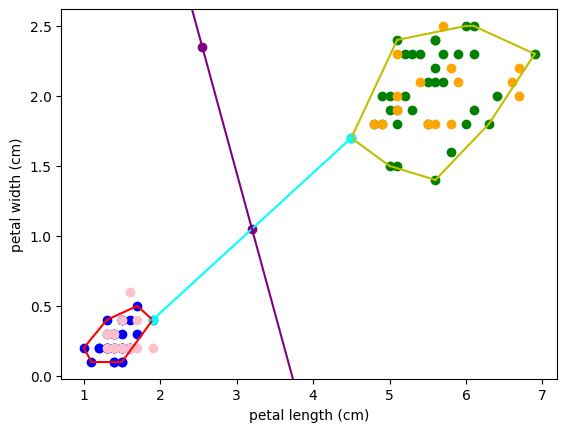

Precisão:  1.0
Revocação:  1.0
F1-Escore:  1.0


In [270]:
# Determine if the setosa and versicolor hulls are linearly separable
printAux = '' if isLinearlySeparable(setosaHull, virginicaHull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

# Get the separation line that separates the setosa and versicolor hulls
closestPoints = getClosestPoints(setosaHull, virginicaHull)
closest_points_segment = Segment(closestPoints[0], closestPoints[1])
separation_segment = getLinearSeparationSegment(closestPoints)

# Classify the test points
concatenatedTestPoints = setosaTestPoints + virginicaTestPoints
classification = classifyPoints(concatenatedTestPoints, separation_segment)

plt.xlabel(iris.feature_names[columnsOfInterest[0]])
plt.ylabel(iris.feature_names[columnsOfInterest[1]])
scatterPlots((setosaTrainingPoints, setosaHull), (virginicaTrainingPoints, virginicaHull))
linearSeparationPlot(closest_points_segment, separation_segment)
plotClusters(classification)
plt.show()

concatenatedTestTargets = [False] * len(setosaTestPoints) + [True] * len(virginicaTestPoints)
concatenatedPredictTargets = [False] * len(classification[0]) + [True] * len(classification[1])

precision, recall, f1 = calculate_metrics(concatenatedTestTargets, concatenatedPredictTargets)

print("Precisão: ", precision)
print("Revocação: ", recall)
print("F1-Escore: ", f1)

#### BASE DE DADOS 2: Setosa vs versicolor

As envoltórias são linearmente separáveis!


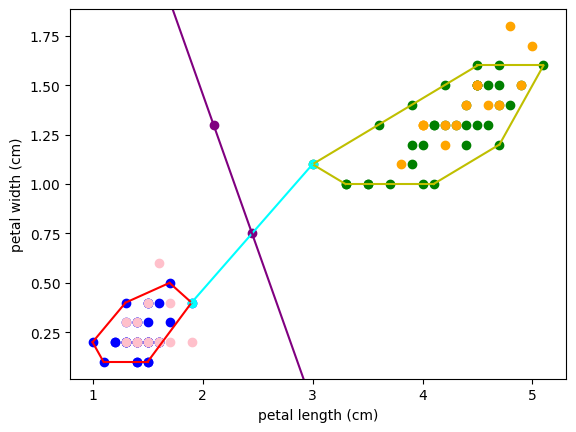

Precisão:  1.0
Revocação:  1.0
F1-Escore:  1.0


In [271]:
printAux = '' if isLinearlySeparable(setosaHull, versicolorHull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

# Get the separation line that separates the setosa and versicolor hulls
closestPoints = getClosestPoints(setosaHull, versicolorHull)
closest_points_segment = Segment(closestPoints[0], closestPoints[1])
separation_segment = getLinearSeparationSegment(closestPoints)

# Classify the test points
concatenatedTestPoints = setosaTestPoints + versicolorTestPoints
classification = classifyPoints(concatenatedTestPoints, separation_segment)

plt.xlabel(iris.feature_names[columnsOfInterest[0]])
plt.ylabel(iris.feature_names[columnsOfInterest[1]])
scatterPlots((setosaTrainingPoints, setosaHull), (versicolorTrainingPoints, versicolorHull))
linearSeparationPlot(closest_points_segment, separation_segment)
plotClusters(classification)
plt.show()

concatenatedTestTargets = [False] * len(setosaTestPoints) + [True] * len(versicolorTestPoints)
concatenatedPredictTargets = [False] * len(classification[0]) + [True] * len(classification[1])

precision, recall, f1 = calculate_metrics(concatenatedTestTargets, concatenatedPredictTargets)

print("Precisão: ", precision)
print("Revocação: ", recall)
print("F1-Escore: ", f1)

#### BASE DE DADOS 3: Virginica vs Versicolor

As envoltórias NÃO são linearmente separáveis!


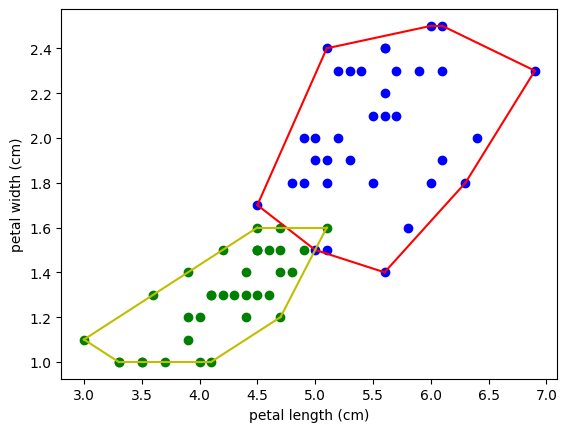

In [272]:
printAux = '' if isLinearlySeparable(virginicaHull, versicolorHull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')
plt.xlabel(iris.feature_names[columnsOfInterest[0]])
plt.ylabel(iris.feature_names[columnsOfInterest[1]])
scatterPlots((virginicaTrainingPoints, virginicaHull), (versicolorTrainingPoints, versicolorHull))

### Bases de dados Wine Recognition

#### BASE DE DADOS 4: Presença de proline e flavanoids em Vinhos distintos

As envoltórias são linearmente separáveis!


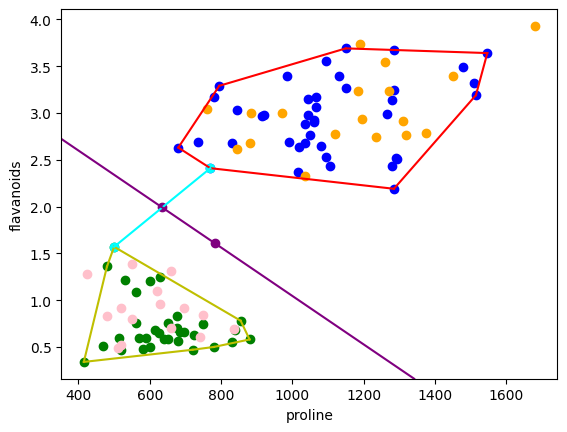

Precisão:  1.0
Revocação:  1.0
F1-Escore:  1.0


In [273]:
wine = load_wine()
wineData = wine.data
wineTarget = np.array(wine.target)

columnsOfInterest = [12, 6] # proline, flavanoids
wineDataOfInterest = wineData[:, columnsOfInterest]

wine0Data = wineDataOfInterest[np.where(wineTarget == 0)]
wine2Data = wineDataOfInterest[np.where(wineTarget == 2)]

wine0Points = datasetToPoints(wine0Data)
wine2Points = datasetToPoints(wine2Data)

concatenatedPoints = wine0Points + wine2Points
transform, revert = min_max_scaling(concatenatedPoints, 0, 10)

(wine0TrainingPoints, wine0TestPoints) = trainTestSplit(wine0Points, 70)
(wine2TrainingPoints, wine2TestPoints) = trainTestSplit(wine2Points, 70)

wine0Hull = giftWrapping(wine0TrainingPoints)
wine2Hull = giftWrapping(wine2TrainingPoints)

# Determine if the wine0 and versicolor hulls are linearly separable
printAux = '' if isLinearlySeparable(wine0Hull, wine2Hull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

normalizedWine0Hull = list(map(transform, wine0Hull))
normalizedWine2Hull = list(map(transform, wine2Hull))

# Get the separation line that separates the wine0 and versicolor hulls
closestPoints = getClosestPoints(normalizedWine0Hull, normalizedWine2Hull)
closest_points_segment = Segment(closestPoints[0], closestPoints[1])
separation_segment = getLinearSeparationSegment(closestPoints)

separation_segment = Segment(revert(separation_segment.p1), revert(separation_segment.p2))
closest_points_segment.p1 = revert(closest_points_segment.p1)
closest_points_segment.p2 = revert(closest_points_segment.p2)

# Classify the test points
concatenatedTestPoints = wine0TestPoints + wine2TestPoints
classification = classifyPoints(concatenatedTestPoints, separation_segment)

plt.xlabel(wine.feature_names[columnsOfInterest[0]])
plt.ylabel(wine.feature_names[columnsOfInterest[1]])
scatterPlots((wine0TrainingPoints, wine0Hull), (wine2TrainingPoints, wine2Hull))
linearSeparationPlot(closest_points_segment, separation_segment)
plotClusters(classification)
plt.show()

concatenatedTestTargets = [False] * len(wine0TestPoints) + [True] * len(wine2TestPoints)
concatenatedPredictTargets = [False] * len(classification[1]) + [True] * len(classification[0])

precision, recall, f1 = calculate_metrics(concatenatedTestTargets, concatenatedPredictTargets)

print("Precisão: ", precision)
print("Revocação: ", recall)
print("F1-Escore: ", f1)

#### BASE DE DADOS 5: Presença de proteínas e tom de cor do vinho

As envoltórias são linearmente separáveis!


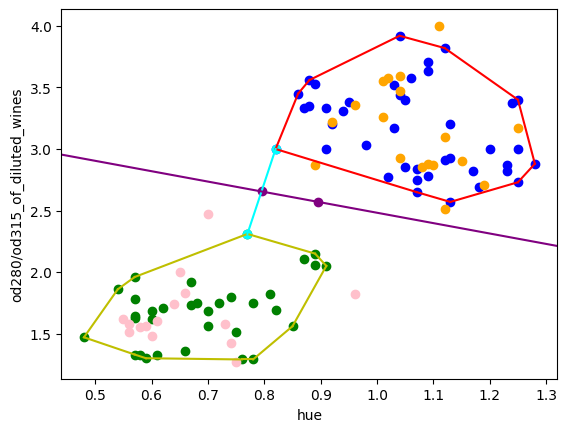

Precisão:  1.0
Revocação:  1.0
F1-Escore:  1.0


In [274]:
wine = load_wine()
wineData = wine.data
wineTarget = np.array(wine.target)

columnsOfInterest = [10, 11] # hue, od280/od315_of_diluted_wines
wineDataOfInterest = wineData[:, columnsOfInterest]

wine0Data = wineDataOfInterest[np.where(wineTarget == 0)]
wine2Data = wineDataOfInterest[np.where(wineTarget == 2)]

wine0Points = datasetToPoints(wine0Data)
wine2Points = datasetToPoints(wine2Data)

concatenatedPoints = wine0Points + wine2Points
transform, revert = min_max_scaling(concatenatedPoints, 0, 10)

(wine0TrainingPoints, wine0TestPoints) = trainTestSplit(wine0Points, 70)
(wine2TrainingPoints, wine2TestPoints) = trainTestSplit(wine2Points, 70)

wine0Hull = giftWrapping(wine0TrainingPoints)
wine2Hull = giftWrapping(wine2TrainingPoints)

# Determine if the wine0 and versicolor hulls are linearly separable
printAux = '' if isLinearlySeparable(wine0Hull, wine2Hull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

normalizedWine0Hull = list(map(transform, wine0Hull))
normalizedWine2Hull = list(map(transform, wine2Hull))

# Get the separation line that separates the wine0 and versicolor hulls
closestPoints = getClosestPoints(normalizedWine0Hull, normalizedWine2Hull)
closest_points_segment = Segment(closestPoints[0], closestPoints[1])
separation_segment = getLinearSeparationSegment(closestPoints)

separation_segment = Segment(revert(separation_segment.p1), revert(separation_segment.p2))
closest_points_segment.p1 = revert(closest_points_segment.p1)
closest_points_segment.p2 = revert(closest_points_segment.p2)

# Classify the test points
concatenatedTestPoints = wine0TestPoints + wine2TestPoints
classification = classifyPoints(concatenatedTestPoints, separation_segment)

plt.xlabel(wine.feature_names[columnsOfInterest[0]])
plt.ylabel(wine.feature_names[columnsOfInterest[1]])
scatterPlots((wine0TrainingPoints, wine0Hull), (wine2TrainingPoints, wine2Hull))
linearSeparationPlot(closest_points_segment, separation_segment)
plotClusters(classification)
plt.show()

concatenatedTestTargets = [False] * len(wine0TestPoints) + [True] * len(wine2TestPoints)
concatenatedPredictTargets = [False] * len(classification[1]) + [True] * len(classification[0])

precision, recall, f1 = calculate_metrics(concatenatedTestTargets, concatenatedPredictTargets)

print("Precisão: ", precision)
print("Revocação: ", recall)
print("F1-Escore: ", f1)

#### BASE DE DADOS 6: Presença de álcool e intensidade da cor

As envoltórias NÃO são linearmente separáveis!


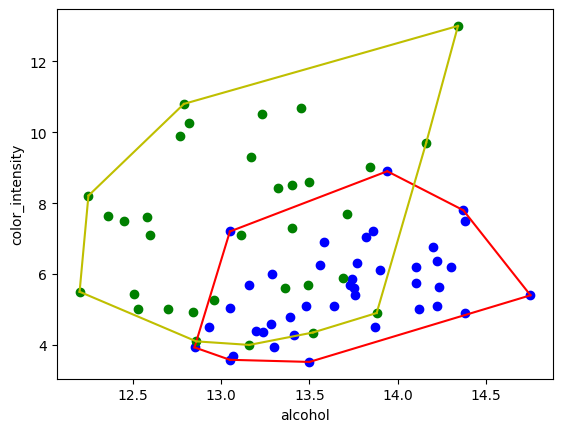

In [275]:
wine = load_wine()
wineData = wine.data
wineTarget = np.array(wine.target)

columnsOfInterest = [0, 9] # alcohol, color intensity
wineDataOfInterest = wineData[:, columnsOfInterest]

wine0Data = wineDataOfInterest[np.where(wineTarget == 0)]
wine2Data = wineDataOfInterest[np.where(wineTarget == 2)]

wine0Points = datasetToPoints(wine0Data)
wine2Points = datasetToPoints(wine2Data)

concatenatedPoints = wine0Points + wine2Points
transform, revert = min_max_scaling(concatenatedPoints, 0, 10)

(wine0TrainingPoints, wine0TestPoints) = trainTestSplit(wine0Points, 70)
(wine2TrainingPoints, wine2TestPoints) = trainTestSplit(wine2Points, 70)

wine0Hull = giftWrapping(wine0TrainingPoints)
wine2Hull = giftWrapping(wine2TrainingPoints)

# Determine if the wine0 and versicolor hulls are linearly separable
printAux = '' if isLinearlySeparable(wine0Hull, wine2Hull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

plt.xlabel(wine.feature_names[columnsOfInterest[0]])
plt.ylabel(wine.feature_names[columnsOfInterest[1]])
scatterPlots((wine0TrainingPoints, wine0Hull), (wine2TrainingPoints, wine2Hull))


#### BASE DE DADOS 7: Tonalidade e Fenóis Totais

As envoltórias são linearmente separáveis!


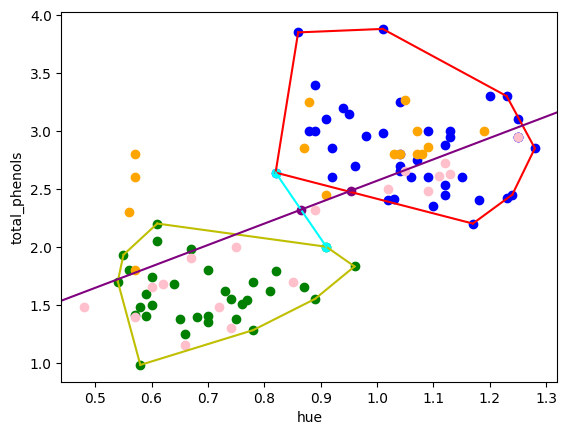

Precisão:  0.8333333333333334
Revocação:  1.0
F1-Escore:  0.9090909090909091


In [276]:

wine = load_wine()
wineData = wine.data
wineTarget = np.array(wine.target)

columnsOfInterest = [10, 5] # hue, total_phenols
wineDataOfInterest = wineData[:, columnsOfInterest]

wine0Data = wineDataOfInterest[np.where(wineTarget == 0)]
wine2Data = wineDataOfInterest[np.where(wineTarget == 2)]

wine0Points = datasetToPoints(wine0Data)
wine2Points = datasetToPoints(wine2Data)

concatenatedPoints = wine0Points + wine2Points
transform, revert = min_max_scaling(concatenatedPoints, 0, 10)

(wine0TrainingPoints, wine0TestPoints) = trainTestSplit(wine0Points, 70)
(wine2TrainingPoints, wine2TestPoints) = trainTestSplit(wine2Points, 70)

wine0Hull = giftWrapping(wine0TrainingPoints)
wine2Hull = giftWrapping(wine2TrainingPoints)

# Determine if the wine0 and versicolor hulls are linearly separable
printAux = '' if isLinearlySeparable(wine0Hull, wine2Hull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

normalizedWine0Hull = list(map(transform, wine0Hull))
normalizedWine2Hull = list(map(transform, wine2Hull))

# Get the separation line that separates the wine0 and versicolor hulls
closestPoints = getClosestPoints(normalizedWine0Hull, normalizedWine2Hull)
closest_points_segment = Segment(closestPoints[0], closestPoints[1])
separation_segment = getLinearSeparationSegment(closestPoints)

separation_segment = Segment(revert(separation_segment.p1), revert(separation_segment.p2))
closest_points_segment.p1 = revert(closest_points_segment.p1)
closest_points_segment.p2 = revert(closest_points_segment.p2)

# Classify the test points
concatenatedTestPoints = wine0TestPoints + wine2TestPoints
classification = classifyPoints(concatenatedTestPoints, separation_segment)

plt.xlabel(wine.feature_names[columnsOfInterest[0]])
plt.ylabel(wine.feature_names[columnsOfInterest[1]])
scatterPlots((wine0TrainingPoints, wine0Hull), (wine2TrainingPoints, wine2Hull))
linearSeparationPlot(closest_points_segment, separation_segment)
plotClusters(classification)
plt.show()

concatenatedTestTargets = [False] * len(wine0TestPoints) + [True] * len(wine2TestPoints)
concatenatedPredictTargets = [False] * len(classification[1]) + [True] * len(classification[0])

precision, recall, f1 = calculate_metrics(concatenatedTestTargets, concatenatedPredictTargets)

print("Precisão: ", precision)
print("Revocação: ", recall)
print("F1-Escore: ", f1)

### Bases de dados Breast cancer wisconsin (diagnostic)

#### BASE DE DADOS 8: Base de dados de câncer de mama, comparação do raio e textura do tumor

As envoltórias NÃO são linearmente separáveis!


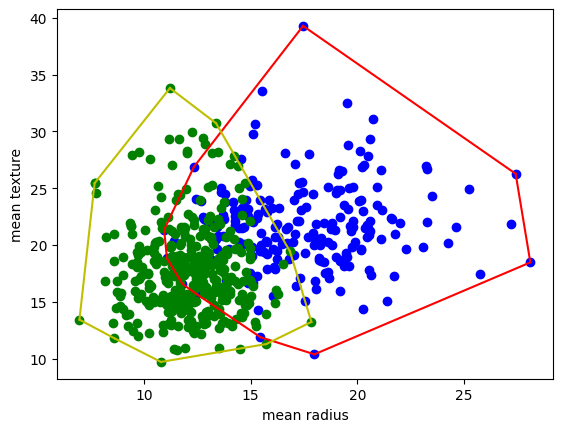

In [277]:
breastCancer = load_breast_cancer()

cancerData = breastCancer.data
cancerTarget = np.array(breastCancer.target)

columnsOfInterest = [0, 1] # mean radius, mean texture
cancerDataOfInterest = cancerData[:, columnsOfInterest] 

malignantData = cancerDataOfInterest[np.where(cancerTarget == 0)]
benignData = cancerDataOfInterest[np.where(cancerTarget == 1)]

malignantPoints = datasetToPoints(malignantData)
benignPoints = datasetToPoints(benignData)

malignantHull = giftWrapping(malignantPoints)
benignHull = giftWrapping(benignPoints)

printAux = '' if isLinearlySeparable(malignantHull, benignHull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

plt.xlabel(breastCancer.feature_names[columnsOfInterest[0]])
plt.ylabel(breastCancer.feature_names[columnsOfInterest[1]])
scatterPlots((malignantPoints, malignantHull), (benignPoints, benignHull))

### Bases de dados Geradas Artificialmente

#### BASE DE DADOS 9: Scikit Learn K-Means sample clusters

As envoltórias são linearmente separáveis!


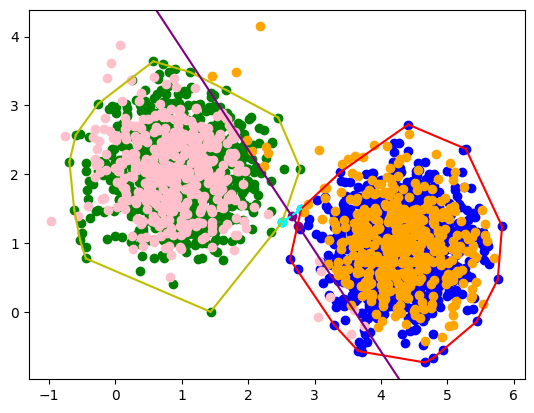

Precisão:  1.0
Revocação:  0.9977777777777778
F1-Escore:  0.9988876529477196


In [278]:
# Generate sample data
n_samples = 3000
n_components = 2

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.55, random_state=0
)
X = X[:, ::-1]

cluster0Data = []
cluster1Data = []
for idx in range(len(X)):
    if y_true[idx] == 0:
        cluster0Data.append(X[idx])
    else:
        cluster1Data.append(X[idx])

cluster0Points = datasetToPoints(cluster0Data)
cluster1Points = datasetToPoints(cluster1Data)

(cluster0TrainingPoints, cluster0TestPoints) = trainTestSplit(cluster0Points, 70)
(cluster1TrainingPoints, cluster1TestPoints) = trainTestSplit(cluster1Points, 70)

cluster0Hull = giftWrapping(cluster0TrainingPoints)
cluster1Hull = giftWrapping(cluster1TrainingPoints)

scatterPlots((cluster0TrainingPoints, cluster0Hull), (cluster1TrainingPoints, cluster1Hull))
# Determine if the wine0 and versicolor hulls are linearly separable
printAux = '' if isLinearlySeparable(cluster0Hull, cluster1Hull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

# Get the separation line that separates the wine0 and versicolor hulls
closestPoints = getClosestPoints(cluster0Hull, cluster1Hull)
closest_points_segment = Segment(closestPoints[0], closestPoints[1])
separation_segment = getLinearSeparationSegment(closestPoints)

# Classify the test points
concatenatedTestPoints = cluster0TestPoints + cluster1TestPoints
classification = classifyPoints(concatenatedTestPoints, separation_segment)

linearSeparationPlot(closest_points_segment, separation_segment)
plotClusters(classification)
plt.show()

concatenatedTestTargets = [False] * len(cluster0TestPoints) + [True] * len(cluster1TestPoints)
concatenatedPredictTargets = [False] * len(classification[1]) + [True] * len(classification[0])

precision, recall, f1 = calculate_metrics(concatenatedTestTargets, concatenatedPredictTargets)

print("Precisão: ", precision)
print("Revocação: ", recall)
print("F1-Escore: ", f1)

#### BASE DE DADOS 10: Exemplo Scikit Learn Kernel PCA 

As envoltórias NÃO são linearmente separáveis!


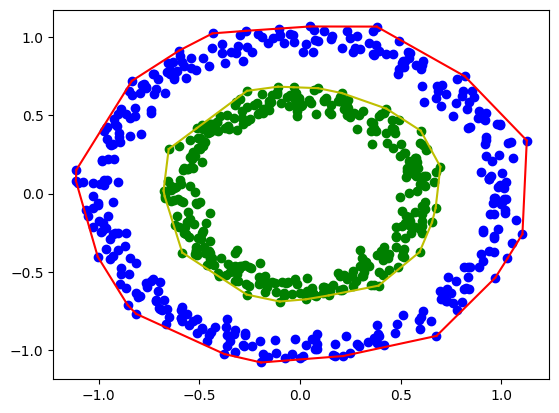

In [279]:
# Generate sample data
n_samples = 1000
X, y_true = make_circles(n_samples=n_samples, factor=0.6, noise=0.05, random_state=0)

cluster0Data = []
cluster1Data = []
for idx in range(len(X)):
    if y_true[idx] == 0:
        cluster0Data.append(X[idx])
    else:
        cluster1Data.append(X[idx])

cluster0Points = datasetToPoints(cluster0Data)
cluster1Points = datasetToPoints(cluster1Data)

(cluster0TrainingPoints, cluster0TestPoints) = trainTestSplit(cluster0Points, 70)
(cluster1TrainingPoints, cluster1TestPoints) = trainTestSplit(cluster1Points, 70)

cluster0Hull = giftWrapping(cluster0TrainingPoints)
cluster1Hull = giftWrapping(cluster1TrainingPoints)

scatterPlots((cluster0TrainingPoints, cluster0Hull), (cluster1TrainingPoints, cluster1Hull))
# Determine if the wine0 and versicolor hulls are linearly separable
printAux = '' if isLinearlySeparable(cluster0Hull, cluster1Hull) else 'NÃO ' 
print('As envoltórias ' + printAux + 'são linearmente separáveis!')

plt.show()